## Random Forest

Author: Elisa Warner
Created: 4/16/2019

Purpose: Check results of SVM against stock data

Change Record:  
6/11/2019 Made Time-Cross Validation be non-overlapping  
6/13/2019 Changed Labels so they are based on de fact RUA Close, not SI. Also added Regression RF  
6/14/2019 Changed Labels back to SI, and moving average, because better score  
6/18/2019 Set the set shift to 0

## Confusion Table Function

In [1]:
###########################
## Create confusion table
###########################

import matplotlib
import matplotlib.pyplot as plt

def prediction_box(predictions, ground_truth):
    ## results
    result = {'tp':0, 'fp':0, 'tn':0, 'fn':0}

    for i in range(len(predictions)):
        #print(pred_test[i], y[i])
        if predictions[i] == ground_truth[i] and ground_truth[i] == 1:
            result['tp'] = result.get('tp', 0) + 1
        elif predictions[i] == ground_truth[i] and ground_truth[i] == 0:
            result['tn'] = result.get('tn', 0) + 1
        elif predictions[i] != ground_truth[i] and ground_truth[i] == 1:
            result['fn'] = result.get('fn', 0) + 1
        else:
            result['fp'] = result.get('fp', 0) + 1

    m = np.array([[result['tp'], result['fn']],[result['fp'],result['fn']]])
    fig, ax = plt.subplots()
    im = ax.imshow(m, cmap='Pastel1')
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(j, i, "{:.2f}".format(m[i,j]), ha="center", va="center")
            plt.title('Predictions for Test Set')
            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])
            ax.set_xticklabels([1, 0])
            ax.set_yticklabels([1, 0])
            plt.ylabel('Ground Truth')
            plt.xlabel('Prediction')

### Remove Missing

In [2]:
def remove_missing(df):
    for col in list(df):
        colvals = df[col].values
        new_colvals = []
        for i in range(len(colvals)):
            if colvals[i] == '.':
                print('Missing found')
                new_colvals.append(colvals[i-1])
            elif pd.isnull(colvals[i]):
                print('nan found')
                new_colvals.append(colvals[i-1])
            else:
                new_colvals.append(colvals[i])
        df[col] = new_colvals
    
    return df

In [3]:
def remove_missing_horz(df):
    new_df = pd.DataFrame()
    for i in range(df.shape[0]):
        row = list(df.iloc[i].values)

        if '.' in row:
            idx_list = [i for i in range(len(row)) if row[i] == ('.')]
            for idx in idx_list:
                row[idx] = row[idx - 1]

        idx_list = [i for i in range(len(row)) if pd.isnull(row[i]) == True]
        for idx in idx_list:
            row[idx] = row[idx - 1]
            
        new_df = new_df.append(pd.DataFrame(row).T, ignore_index = True)
    
    return new_df

## 1. Load Data

In [4]:
#!pip3 install -U scikit-learn scipy matplotlib

In [5]:
import pandas as pd
from sklearn import svm
import numpy as np

In [6]:
file1 = "./Combined_Sets_from_Revised.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
print(train_pd.shape)

(7120, 423)


In [7]:
#train_pd[5902:7100] # Google Trends part

In [8]:
train_pd = train_pd[1:7070] #[5902:7100]

train = np.array(train_pd)
train.shape

(7069, 423)

In [9]:
train = train[:, :149] # drop google columns
train = pd.DataFrame(train)
train = train.dropna() # drop any nan rows
train.shape
train = np.array(train)

In [10]:
train = train[:,2:] # drop date, keep label
train

array([[1, 176.259995, 8.02, ..., 388.5, 390.4, 395.35],
       [1, 173.199997, 8.13, ..., 390.4, 395.35, 398.0],
       [1, 172.779999, 8.16, ..., 395.35, 398.0, 403.7],
       ...,
       [0, 1555.099976, 2.755, ..., 1312.95, 1322.5, 1320.75],
       [0, 1558.880005, 2.7119999999999997, ..., 1322.5, 1320.75, 1311.0],
       [0, 1573.310059, 2.753, ..., 1320.75, 1311.0, 1314.0]],
      dtype=object)

## 2. Time-Series Cross validation

In [ ]:
def time_cross(array, time_shift = 0, size_train_set = 365, size_val_set = 100, set_shift = 0):
    np.random.seed(100)
    label_idx = 0

    if time_shift == 0:
        time_shift = size_train_set + size_val_set + set_shift
        
    train_size = train.shape
    j = 0
    group = 1
    end = train_size[0]
    trainDataPartition = [] # list
    valDataPartition = []

    #print(size_train_set, size_val_set, train_size[0])
    while j + (size_train_set + size_val_set + set_shift) < train_size[0]:
        trainset = []
        valset = []

        trainset = train[j:j+size_train_set, :] # array
        valset = train[j+size_train_set+1+set_shift:j+size_train_set+size_val_set+set_shift, :]

        trainDataPartition.append(trainset)
        valDataPartition.append(valset)
    
        group = group+1;
        j = j + time_shift


    # make last set -- decide if you want to throw out or adjust this set
    print('Last set:', j, j+size_train_set)
    trainset = train[j:j+size_train_set, :]
    valset = train[j+size_train_set+1+set_shift:end, :]
    #print(trainset)
    #print(valset)
    
    trainDataPartition.append(trainset)
    valDataPartition.append(valset)

    
    ### Optional: stratify
    revised_trainDataPartition = []
    revised_valDataPartition = []
    
    for i in range(len(trainDataPartition)):
        trainset = trainDataPartition[i]
        valset = valDataPartition[i] # Do the same for validation set
        
        print(trainset.shape[0], valset.shape[0])
        records = trainset[:,0] # record of labels for training set
        records_val = valset[:, 0] # record of labels for validation set
        #print(sum(records == 1), sum(records == 0))
        #print(sum(records_val == 1), sum(records_val == 0))
        
        ############ FOR TRAINING SET ################
        if sum(records == 1) == 0 or sum(records == 0) == 0:
            revised_trainDataPartition.append(np.nan)
        elif sum(records == 1) > sum(records == 0):
            while sum(records == 1) >= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                #print(r)
                if records[r] == 1:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
            
        else:
            while sum(records == 1) <= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                if records[r] == 0:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
        #print(sum(records == 1), sum(records == 0))
        
        ############## FOR VALIDATION SET ################
        if sum(records_val == 1) == 0 or sum(records_val == 0) == 0:
            revised_valDataPartition.append(np.nan)
        elif sum(records_val == 1) > sum(records_val == 0):
            while sum(records_val == 1) >= 1.3 * sum(records_val == 0):
                r = round(np.random.rand() * (valset.shape[0]-1))
                #print(r)
                if records_val[r] == 1:
                    valset = np.delete(valset, r, 0)
                    records_val = np.delete(records_val, r)
            revised_valDataPartition.append(valset)
        else:
            while sum(records_val == 1) <= 1.3 * sum(records_val == 0):
                r = round(np.random.rand() * (valset.shape[0]-1))
                if records_val[r] == 0:
                    valset = np.delete(valset, r, 0)
                    records_val = np.delete(records_val, r)

            revised_valDataPartition.append(valset)

    group = len(revised_trainDataPartition)
    group_val = len(revised_valDataPartition)
    print('Number of groups:', group, group_val)
    
    return revised_trainDataPartition, revised_valDataPartition, group

In [ ]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 260, 30)

In [ ]:
t = pd.DataFrame(valDataPartition[1])
t.head(n=10)

In [ ]:
#trainDataPartition[18]
t = pd.DataFrame(trainDataPartition[0])
t.head(n=10)

## 3. Random Forest Implementation
No normalization necessary for Random Forest

In [ ]:
##############################################################################
### Try Random Forest Classifier

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
def rf(train_list, val_list, group):
    splits = group
    score = []

    #kf = sklearn.model_selection.KFold(n_splits=splits, random_state = 10, shuffle = True)
    #kf.get_n_splits(features)

    data_size = trainDataPartition[0].shape

    for idx in range(len(trainDataPartition)-1):
            # print("TRAIN:", train_index, "TEST:", test_index)
            try:
                X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
                y_train = y_train.astype('int')
                #print(X_train)
                X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
                y_test = y_test.astype('int')
                print('train:', sum(y_train), len(y_train))
                print('test:', sum(y_test), len(y_test))

                # Fit the RF model
                clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0)
                clf.fit(X_train, y_train)
                
                # print predicitions
                pred = clf.predict(X_test)
                #print(pred)

            except:
                print('Skipped due to NaN')
                continue # nan
                
            # add up AUROCs            
            try:
                temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
                #temp_score = sklearn.metrics.accuracy_score(y_test,pred)
                #score = score + sklearn.metrics.accuracy_score(y_test, pred)
                #temp_score = sum([1 for i in range(len(pred)) if pred[i] == y_test[i]]) / len(pred)
                score.append(temp_score)
                print(temp_score)
            except:
                pass


    # calculate average
    score = np.mean(score)
    print("Averaged Score is: %0.4f" % score, splits)


    # print(clf.feature_importances_)
    
    return score

In [ ]:
print('groups', group)
rf(valDataPartition, trainDataPartition, group)

Hyperparameter Test

In [ ]:
### Test
# time_shift, size_train_set, size_val_set

time_shift = [0] # smaller time shift is better, smaller training set, smaller val set 0, 50, 100, 126, 252, 504
# 504 252 50 0.61268998
size_train_set = [100, 252, 410]
size_val_set = [50, 100, 260] # predict a month ahead (shift labels)

score_matrix = np.zeros((len(time_shift), len(size_train_set), len(size_val_set)))
settings_matrix = np.zeros((len(size_train_set), len(size_val_set)), dtype = 'i,i')

for i in range(len(time_shift)):
    for j in range(len(size_train_set)):
        for k in range(len(size_val_set)):
            print(time_shift, size_train_set[j], size_val_set[k])
            trainDataPartition, valDataPartition, group = time_cross(train, time_shift[i], size_train_set[j], size_val_set[k], 0)

            #time_shift[i]
            try:
                score_matrix[i][j][k] = rf(valDataPartition, trainDataPartition, group)
            except:
                print('Cannot compute score')
            settings_matrix[j][k][0] = size_train_set[j]
            settings_matrix[j][k][1] = size_val_set[k]
            
print(np.argmax(score_matrix, axis = 1))
print(score_matrix)
print(settings_matrix)
#0.61268998 Didn't work so well with Label 2
# Perfomed well with predicting next day with Google Trends 0.8975, best was 0.96

In [ ]:
t = np.max(score_matrix, axis = 1)
#print(np.argmax(t, axis = 1))
t

# Look for Feature Importances

In [ ]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 252, 260, 0) #10 252 100 Draft_Google_shorter 0.8795

In [ ]:
splits = group
score_list = []
indices = []
pred_labels = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
        pred_labels.append(pred)
        print(pred)
        #print(pred)
    except:
        print('Skipped')
        continue #np.nan
        
    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

Plot the accuracy through time

In [ ]:
import matplotlib.pyplot as plt
print("Standard Deviation:", np.std(score_list))
print(indices)
plt.figure()
plt.plot(indices, score_list)
plt.title('Performance across Folds')
plt.show()

Which features are important during the time when the datasets are accurate?

In [ ]:
indices = [x for x in range(len(score_list)) if score_list[x] > 0.5]
importance = np.array([])
count = 0

for idx in range(0, len(trainDataPartition)): # for several months of 2012, May - end of November, 1180, 1281
    # run random forest
    try:

        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')

        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
    
        if not importance.any():
            print('hi')
            importance = clf.feature_importances_
        else:
            importance = importance + clf.feature_importances_

        count+=1
    except:
        continue #np.nan

    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass

In [ ]:
importance = importance / count
feature_indices = np.argsort(importance)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importance[feature_indices],
       color="r", align="center") # X_train.shape[1]
plt.xticks(range(X_train.shape[1]), feature_indices) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [ ]:
name = 'Combined_Sets_from_Revised.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(feature_indices)-1):
    idx = feature_indices[i]
    print(listoffeatures[idx], importance[idx])
    if i <= 25:
        shortlist.append(listoffeatures[idx])
shortlist

# Feature Importance

In [ ]:
# Create a graph of fetaure importances

import matplotlib.pyplot as plt

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(100), importances[indices[0:100]],
       color="r", yerr=std[indices[0:100]], align="center") # X_train.shape[1]
plt.xticks(range(100), indices[0:100]) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [ ]:
print(len(clf.feature_importances_))
print(len(list(train_pd)[1:]))

In [ ]:
name = '../Data/Combined_Sets_from_Revised_3.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

In [ ]:
# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(indices)-1):
    idx = indices[i]
    print(listoffeatures[idx], importances[idx])
#    if i <= 50:
#        shortlist.append(listoffeatures[i])

# SVM

In [ ]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 252, 260, 0) #10 252 100 Draft_Google_shorter 0.8795

In [ ]:
test = pd.DataFrame(valDataPartition[1])

In [ ]:
splits = group
score_list = []
good_sets = []
gammas = []
indices = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
        #print(1 / (X_train.shape[1] * X_train.var()))
        # Fit the RF model

        #gamma =  (1 / (X_train.shape[1] * X_train.var()))
        clf = sklearn.svm.SVC(C=.4, kernel='rbf', gamma='scale') # previously 7
        clf.fit(X_train, y_train)
        
        
        # print predicitions
        pred = clf.predict(X_test)
        #print(pred)
    except:
        continue

    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
        if temp_score > 0.7:
            good_sets.append(idx)
            gammas.append(1 / (X_train.shape[1] * X_train.var()))
    except:
        pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

In [ ]:
import matplotlib.pyplot as plt
print("Standard Deviation:", np.std(score_list))
print(indices)
plt.figure()
plt.plot(indices, score_list)
plt.title('Performance across Folds')
plt.show()

In [ ]:
good_sets

In [ ]:
pred_labels2 = []
for predlist in pred_labels:
    for x in range(len(predlist)):
        pred_labels2.append(predlist[x])
pred_labels2

# Random Forest Regressor

In [11]:
def simple_time_cross(array, time_shift = 0, size_train_set = 365, size_val_set = 100, set_shift = 0):
    np.random.seed(100)
    label_idx = 0

    if time_shift == 0:
        time_shift = size_train_set + size_val_set + set_shift
        
    train_size = train.shape
    j = 0
    group = 1
    end = train_size[0]
    trainDataPartition = [] # list
    valDataPartition = []

    #print(size_train_set, size_val_set, train_size[0])
    while j + (size_train_set + size_val_set + set_shift) < train_size[0]:
        trainset = []
        valset = []

        trainset = train[j:j+size_train_set, :] # array
        valset = train[j+size_train_set+1+set_shift:j+size_train_set+size_val_set+set_shift, :]

        trainDataPartition.append(trainset)
        valDataPartition.append(valset)
    
        group = group+1;
        j = j + time_shift


    # make last set -- decide if you want to throw out or adjust this set
    print('Last set:', j, j+size_train_set)
    trainset = train[j:j+size_train_set, :]
    valset = train[j+size_train_set+1+set_shift:end, :]
    #print(trainset)
    #print(valset)
    
    trainDataPartition.append(trainset)
    valDataPartition.append(valset)

    group = len(trainDataPartition)
    group_val = len(valDataPartition)
    print('Number of groups:', group, group_val)
    
    return trainDataPartition, valDataPartition, group

In [12]:
train = np.array(train_pd)
train = train[:, :149] # drop google columns
#train = train[5902:, :]
train.shape

(7069, 149)

In [13]:
train = pd.DataFrame(train)
train = train.dropna() # drop any nan rows
train = np.array(train)

In [14]:
train.shape

(7048, 149)

In [15]:
labels = train[:,1]
train = train[:, 3:train.shape[1]]

In [16]:
labels = labels.reshape((train.shape[0], 1))

PCA

In [ ]:
train = train.T

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(train)  
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
pca.explained_variance_ratio_

In [ ]:
train2 = pca.components_
train2.shape
train = train2.T

Return

In [17]:
train = np.concatenate((labels, train), axis = 1)

In [18]:
train.shape

(7048, 147)

In [19]:
[trainDataPartition, valDataPartition, group] = simple_time_cross(train, 0, 460, 210, 0) #410 100

Last set: 6700 7160
Number of groups: 11 11


In [20]:
trainDataPartition[0]

array([[206.600006, 176.259995, 8.02, ..., 388.5, 390.4, 395.35],
       [210.850006, 173.199997, 8.13, ..., 390.4, 395.35, 398.0],
       [209.25, 172.779999, 8.16, ..., 395.35, 398.0, 403.7],
       ...,
       [250.38999900000002, 236.190002, 6.83, ..., 338.8, 339.3, 338.75],
       [251.149994, 236.24000499999997, 6.78, ..., 339.3, 338.75, 336.9],
       [253.13999900000002, 237.25, 6.76, ..., 338.75, 336.9, 337.45]],
      dtype=object)

Random/SVM Forest Regression

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics

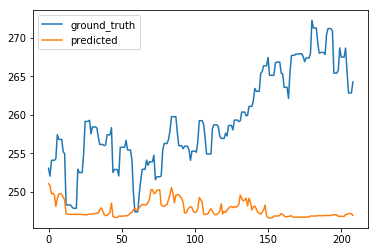

Mean Squared Error: 177.24835760464475
-3.7761995060073863


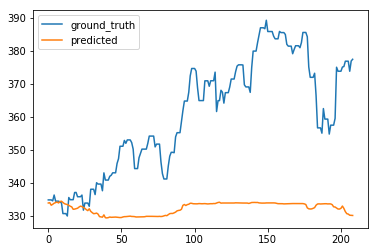

Mean Squared Error: 1047.6905652633188
-2.5051917150196483


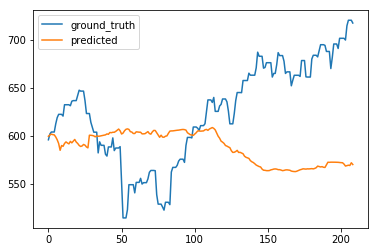

Mean Squared Error: 5697.669079725799
-1.1451735043430191


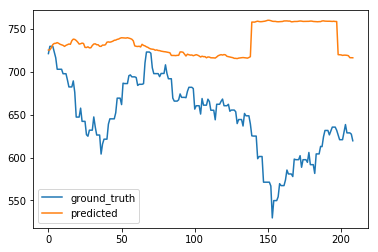

Mean Squared Error: 10770.495369983568
-4.856536847739738


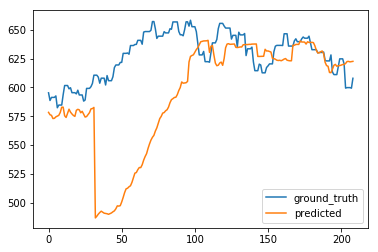

Mean Squared Error: 3188.1051601863296
-6.944335530947673


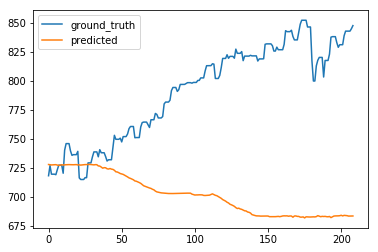

Mean Squared Error: 11275.100585089855
-5.648608889202628


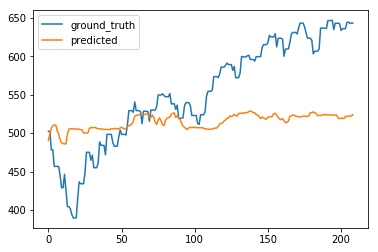

Mean Squared Error: 5143.946972775968
-0.10354843461636953


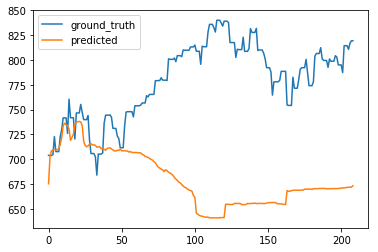

Mean Squared Error: 13538.913107464847
-8.203560396648331


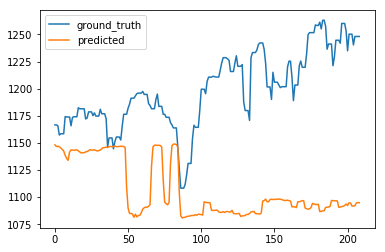

Mean Squared Error: 11177.21061370804
-8.104613139518086


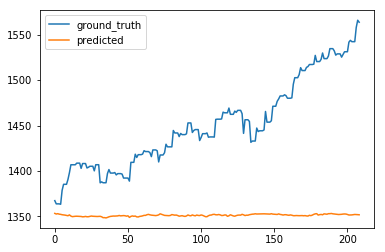

Mean Squared Error: 12139.753242242577
-4.193321094440553
Averaged Score is: -4.5481 11


In [22]:
splits = group
score_list = []
good_sets = []
gammas = []
indices = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        #y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        #y_test = y_test.astype('int')
        #print(1 / (X_train.shape[1] * X_train.var()))
        # Fit the RF model

        #gamma =  (1 / (X_train.shape[1] * X_train.var()))
        #clf = SVR(C=1, epsilon=0.0001, gamma='scale', \
        #          kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
        clf = RandomForestRegressor(max_depth = 20, n_estimators=1500, random_state=4, criterion = 'mse') # previously 7
        clf.fit(X_train, y_train)
        
        
        # print predicitions
        pred = clf.predict(X_test)
        #print(pred)

        plt.plot(y_test, label = 'ground_truth')
        plt.plot(pred, label = 'predicted')
        plt.legend()
        plt.show()
        print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
        # add up AUROCs
    except:
        continue
            
    #try:
    #SS_tot = sum((y_test - np.mean(y_test))**2)
    #S_res = sum((y_test - pred) ** 2)
    #temp_score = 1 - (SS_res / SS_tot)
    temp_score = metrics.r2_score(y_test, pred)
    score_list.append(temp_score)
    indices.append(idx)
    print(temp_score)
    if temp_score > 0.7:
        good_sets.append(idx)
        gammas.append(1 / (X_train.shape[1] * X_train.var()))
    #except:
    #    pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

A plot by itself

In [ ]:
plt.plot(y_test, label = 'ground_truth')
plt.plot(pred, label = 'predicted')
plt.legend()
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))

In [ ]:
X_test[:,95]

In [ ]:
trainDataPartition[0]